In [1]:
import numpy as np
import os
import cv2
import torch
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from torchvision import transforms
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader


In [20]:
data_path = '/content/drive/MyDrive/NMA_DL_project/data_npy_format'
model_path = '/content/drive/MyDrive/NMA_DL_project/models'

if os.path.isdir(model_path):
  pass
else:
  os.mkdir(model_path)

In [14]:
def resize(X,xy=(200, 200)):
    reshape_im = []
    for n in range(X.shape[0]):
        reshape_im.append(cv2.resize(X[n,0],xy))
    reshape_im = np.array(reshape_im)
    reshape_im = np.array(np.expand_dims(reshape_im,axis=1))
    return reshape_im

# Load the images
orig_image = np.load(os.path.join(data_path,'images_without_HC_small.npy'))
orig_image = np.expand_dims(orig_image, axis=1)
image_resize = resize(orig_image,xy = (256,256))
print(orig_image.shape, image_resize.shape)

5000
(5000, 1, 197, 197) (5000, 1, 256, 256)


In [16]:
data_transforms = transforms.Compose([
transforms.ToPILImage(),
# transforms.Scale(256),
transforms.ToTensor(),
transforms.RandomAdjustSharpness(sharpness_factor=10, p=1),
transforms.ColorJitter(brightness=2, contrast=0, saturation=0, hue=0)
])


In [17]:
image_trans = []
for i in range(image_resize.shape[0]):
  image_trans.append(data_transforms(image_resize[i][0]).numpy())
image_trans = np.array(image_trans)

print(image_trans.shape)

(5000, 1, 256, 256)


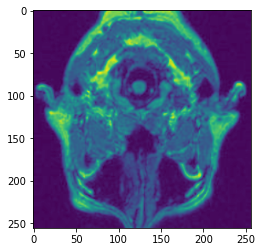

In [15]:
plt.imshow(image_resize[0][0])
plt.show()

4999
(256, 256)
Check your dimensions!
(256, 256)


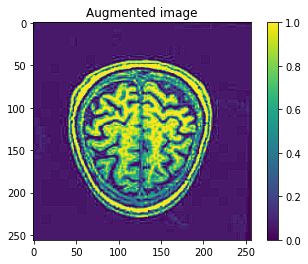

In [18]:
def plot_an_image(img,title="Augmented image"):
  if img.shape[0]==1:
    img = img[0]
  else:
    print("Check your dimensions!")
  print(img.shape)
  plt.imshow(img)
  plt.title(title)
  plt.colorbar()
  plt.show()

idx = 0
idx+=i
print(idx)
plot_an_image(image_trans[idx],title="Augmented image")

In [124]:
norm_layer = nn.InstanceNorm2d
class ResBlock(nn.Module):
    def __init__(self, f):
        super(ResBlock, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(f, f, 3, 1, 1), norm_layer(f), nn.ReLU(),
                                  nn.Conv2d(f, f, 3, 1, 1))
        self.norm = norm_layer(f)
    def forward(self, x):
        return F.relu(self.norm(self.conv(x)+x))

class Generator(nn.Module):
    def __init__(self, f=64, blocks=9):
        super(Generator, self).__init__()
        layers = [nn.ReflectionPad2d(3),
                  nn.Conv2d(  3,   f, 7, 1, 0), norm_layer(  f), nn.ReLU(True),
                  nn.Conv2d(  f, 2*f, 3, 2, 1), norm_layer(2*f), nn.ReLU(True),
                  nn.Conv2d(2*f, 4*f, 3, 2, 1), norm_layer(4*f), nn.ReLU(True)]
        for i in range(int(blocks)):
            layers.append(ResBlock(4*f))
        layers.extend([
                nn.ConvTranspose2d(4*f, 4*2*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(2*f), nn.ReLU(True),
                nn.ConvTranspose2d(2*f,   4*f, 3, 1, 1), nn.PixelShuffle(2), norm_layer(  f), nn.ReLU(True),
                nn.ReflectionPad2d(3), nn.Conv2d(f, 3, 7, 1, 0),
                nn.Tanh()])
        self.conv = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.conv(x)

In [129]:
nc=1
ndf=64
class Discriminator(nn.Module):  
    def __init__(self):
        super(Discriminator, self).__init__()
        self.main = nn.Sequential(
            # input is (nc) x 128 x 128
            nn.Conv2d(nc,ndf,4,2,1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf) x 64 x 64
            nn.Conv2d(ndf,ndf*2,4,2,1, bias=False),
            nn.InstanceNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*2) x 32 x 32
            nn.Conv2d(ndf*2, ndf * 4, 4, 2, 1, bias=False),
            nn.InstanceNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*4) x 16 x 16
            nn.Conv2d(ndf*4,ndf*8,4,1,1),
            nn.InstanceNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. (ndf*8) x 15 x 15
            nn.Conv2d(ndf*8,1,4,1,1)
            # state size. 1 x 14 x 14
        )

    def forward(self, input):
        return self.main(input)

In [130]:
def LSGAN_D(real, fake):
  return (torch.mean((real - 1)**2) + torch.mean(fake**2))

def LSGAN_G(fake):
  return  torch.mean((fake - 1)**2)

In [133]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

G_A2B = Generator().to(device)
G_B2A = Generator().to(device)
D_A = Discriminator().to(device)
D_B = Discriminator().to(device)

# Initialize Loss function
criterion_Im = torch.nn.L1Loss() 

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Optimizers

In [135]:
# dataloader_zebra_train = torch.utils.data.DataLoader(dataset_zebra_train, batch_size=bs,
                                        #  shuffle=True, num_workers=workers)

from torch.utils.data import TensorDataset, DataLoader

my_x = image_trans 
my_y = images 

tensor_x = torch.Tensor(my_x) # transform to torch tensor
tensor_y = torch.Tensor(my_y)

my_dataset = TensorDataset(tensor_x,tensor_y) # create your datset
my_dataloader = DataLoader(my_dataset) # create your dataloader

In [146]:
image_trans.shape

(5000, 1, 256, 256)

In [145]:
for  i,j in my_dataloader:
  print(i[0].shape,j[0].shape)
  break

torch.Size([1, 256, 256]) torch.Size([197, 197])


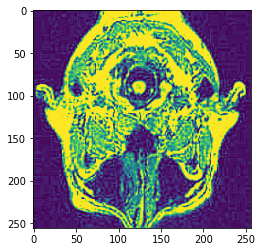

In [142]:
plt.imshow(i[0][0,0])
plt.show()

In [139]:
def training(G_A2B, G_B2A, D_A, D_B,num_epochs,name,old = True):

  

  # Training Loop

  # Lists to keep track of progress
  img_list = []
  G_losses = []
  D_A_losses = []
  D_B_losses = []


  iters=0
  FDL_A2B = []
  FDL_B2A = []
  CL_A = []
  CL_B = []
  ID_B2A = []
  ID_A2B = []
  disc_A = []
  disc_B = []


  FDL_A2B_t = []
  FDL_B2A_t = []
  CL_A_t = []
  CL_B_t = []
  ID_B2A_t = []
  ID_A2B_t = []
  disc_A_t = []
  disc_B_t = []

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):

    # For each batch in the dataloader
    for  i,(data_horse, data_zebra) in enumerate(zip(dataloader_train_horses, dataloader_zebra_train),0):
    
        # Set model input
        a_real = data_horse[0].to(device)
        b_real = data_zebra[0].to(device)
      
        tensor_ones=torch.ones([a_real.shape[0],1,14,14]).cuda()
        tensor_zeros=torch.zeros([a_real.shape[0],1,14,14]).cuda()

        # Genrated images
        b_fake = G_A2B(a_real)
        a_rec = G_B2A(b_fake)
        a_fake = G_B2A(b_real)
        b_rec = G_A2B(a_fake)


        # Discriminator A
        optimizer_D_A.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_a_fake.shape[0]-1)
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(old_a_fake[rand_int-5:rand_int].detach()))
          D_A_losses.append(Disc_loss_A.item())

        else:
          Disc_loss_A = LSGAN_D(D_A(a_real), D_A(a_fake.detach()))
          D_A_losses.append(Disc_loss_A.item())
        
        Disc_loss_A.backward()
        optimizer_D_A.step()

        
        # Discriminator B

        optimizer_D_B.zero_grad()
        if((iters > 0 or epoch > 0) and old and iters % 3 == 0):
          rand_int = random.randint(5, old_b_fake.shape[0]-1)
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(old_b_fake[rand_int-5:rand_int].detach()))
          D_B_losses.append(Disc_loss_B.item())
        else:
          Disc_loss_B =  LSGAN_D(D_B(b_real), D_B(b_fake.detach()))
          D_B_losses.append(Disc_loss_B.item())

        Disc_loss_B.backward()
        optimizer_D_B.step()   

        # Generator

        optimizer_G_A2B.zero_grad()
        optimizer_G_B2A.zero_grad()


        # Fool discriminator
        Fool_disc_loss_A2B = LSGAN_G(D_B(b_fake))
        Fool_disc_loss_B2A = LSGAN_G(D_A(a_fake))

        # Cycle Consistency    both use the two generators
        Cycle_loss_A = criterion_Im(a_rec, a_real)*5
        Cycle_loss_B = criterion_Im(b_rec, b_real)*5

        # Identity loss
        Id_loss_B2A = criterion_Im(G_B2A(a_real), a_real)*10
        Id_loss_A2B = criterion_Im(G_A2B(b_real), b_real)*10

        # generator losses


        Loss_G = Fool_disc_loss_A2B+Fool_disc_loss_B2A+Cycle_loss_A+Cycle_loss_B+Id_loss_B2A+Id_loss_A2B
        G_losses.append(Loss_G)

        # Backward propagation
        Loss_G.backward()
        
        
        # Optimisation step
        optimizer_G_A2B.step()
        optimizer_G_B2A.step()

        FDL_A2B.append(Fool_disc_loss_A2B)
        FDL_B2A.append(Fool_disc_loss_B2A)
        CL_A.append(Cycle_loss_A)
        CL_B.append(Cycle_loss_B)
        ID_B2A.append(Id_loss_B2A)
        ID_A2B.append(Id_loss_A2B)
        disc_A.append(Disc_loss_A)
        disc_B.append(Disc_loss_B)

        if(iters == 0 and epoch == 0):
          old_b_fake = b_fake.clone()
          old_a_fake = a_fake.clone()
        elif (old_b_fake.shape[0] == bs*5 and b_fake.shape[0]==bs):
          rand_int = random.randint(5, 24)
          old_b_fake[rand_int-5:rand_int] = b_fake.clone()
          old_a_fake[rand_int-5:rand_int] = a_fake.clone()
        elif(old_b_fake.shape[0]< 25):
          old_b_fake = torch.cat((b_fake.clone(),old_b_fake))
          old_a_fake = torch.cat((a_fake.clone(),old_a_fake))

        iters += 1
        del data_zebra, data_horse, a_real, b_real, a_fake, b_fake


        if iters % 50 == 0:
      
          print('[%d/%d]\tFDL_A2B: %.4f\tFDL_B2A: %.4f\tCL_A: %.4f\tCL_B: %.4f\tID_B2A: %.4f\tID_A2B: %.4f\tLoss_D_A: %.4f\tLoss_D_A: %.4f'
                      % (epoch+1, num_epochs, Fool_disc_loss_A2B, Fool_disc_loss_B2A,Cycle_loss_A,Cycle_loss_B,Id_loss_B2A,
                          Id_loss_A2B, Disc_loss_A.item(), Disc_loss_B.item()))
        

    FDL_A2B_t.append(sum(FDL_A2B)/len(FDL_A2B))
    FDL_B2A_t.append(sum(FDL_B2A)/len(FDL_B2A))
    CL_A_t.append(sum(CL_A)/len(CL_A))
    CL_B_t.append(sum(CL_B)/len(CL_B))
    ID_B2A_t.append(sum(ID_B2A)/len(ID_B2A))
    ID_A2B_t.append(sum(ID_A2B)/len(ID_A2B))
    disc_A_t.append(sum(disc_A)/len(disc_A))
    disc_B_t.append(sum(disc_B)/len(disc_B))

    FDL_A2B = []
    FDL_B2A = []
    CL_A = []
    CL_B = []
    ID_B2A = []
    ID_A2B = []
    disc_B = []
    disc_A = []

    iters = 0             
    save_models(G_A2B, G_B2A, D_A, D_B, name)
    if (epoch % 5 == 0):
      plot_images_test(dataloader_test_horses, dataloader_zebra_test)
    #plot_all_images(4, dataloader_test_horses, dataloader_zebra_test)
  return(FDL_A2B_t,FDL_B2A_t,CL_A_t,CL_B_t,ID_B2A_t,ID_A2B_t,disc_A_t,disc_B_t)

In [ ]:
name="Basic9_old_256_training50"
#name="Basic9_training50"
#name = 'basic_training50'
epochs=20
netG_A2B, netG_B2A, netD_A, netD_B=G_A2B, G_B2A, D_A, D_B

optimizer_G_A2B = torch.optim.Adam(G_A2B.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_G_B2A = torch.optim.Adam(G_B2A.parameters(), lr=lr, betas=(beta1, 0.999))

optimizer_D_A = torch.optim.Adam(D_A.parameters(), lr=lr, betas=(beta1, 0.999))
optimizer_D_B = torch.optim.Adam(D_B.parameters(), lr=lr, betas=(beta1, 0.999))

losses = training( netG_A2B, netG_B2A, netD_A, netD_B,epochs,name)
